In [73]:
#!pip3 install tensorflow
#!pip3 install node2vec
import pickle
import networkx as nx
from node2vec import Node2Vec
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random
import math
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from tensorflow import keras
import tensorflow as tf
from sklearn.naive_bayes import GaussianNB, ComplementNB, CategoricalNB

In [2]:
EMBEDDING_FILENAME = './embeddings.emb'
EMBEDDING_MODEL_FILENAME = './embeddings.model'

In [69]:
# functions

#display graph
def display_graph(G):
    plt.figure(figsize=(20,20))
    nx.draw_kamada_kawai(G, node_size=100, node_color='yellow', with_labels=True, nodetype = int)
    return

# node2vec for each node
def create_n2v_dict(G):
    # get node to vec embeddings
    node2vec = Node2Vec(G, dimensions=50, walk_length=5, num_walks=5, workers=4)  
    model = node2vec.fit(window=10, min_count=1, batch_words=4)  
    model.wv.save_word2vec_format(EMBEDDING_FILENAME)
    model.save(EMBEDDING_MODEL_FILENAME)
    emb = pd.read_csv(EMBEDDING_FILENAME, "r")
    
    n2v = dict()
    for i in range(len(emb)):
        tmp = list(emb.iloc[i])[0].split(" ")
        n2v[tmp[0]] = list(map(float, tmp[1:]))
    return n2v

# create implicit feature dictionary
def create_feat_dict(feat):
    feat_dict = dict()
    for i in range(len(feat)):
        tmp = list(feat.loc[i])[0].split(' ')
        tmp = [int(i) for i in tmp]
        #print(tmp)
        feat_dict[str(tmp[0])] = tmp[1:]
    return feat_dict

In [4]:
#Extracting dataframes

feat_names = pd.read_csv("facebook/0.featnames")
edges = pd.read_csv("facebook/0.edges")
feat = pd.read_csv("facebook/0.feat", names = ['vector'])
circles = pd.read_csv("facebook/0.circles")

In [5]:
# building the graph

#edgelist is needed for read_edgelist
edge_df = open("facebook/0.edges", "rb")
G = nx.read_edgelist(edge_df)

        

In [6]:
#Building edge_dict

# getting nodes and edges for dataframe from graph
print(len(G.nodes))
print(len(G.edges))

node_list = list(np.unique(G.nodes))
edge_list = list(G.edges)


entries = []

# all_edges dictionary
edge_dict = dict()


for node1 in node_list:
    for node2 in node_list:
        if node1 != node2 and (node1, node2) not in edge_dict and (node2, node1) not in edge_dict:
            if (node1, node2) in edge_list:
                edge_dict[(node1, node2)] = 1
            elif (node2, node1) in edge_list:
                edge_dict[(node2, node1)] = 1
            else:
                edge_dict[(node1, node2)] = 0
                
print(len(edge_list))
print(len(edge_dict))                


333
2519
2519
55278


In [7]:
n2v = create_n2v_dict(G)

feat_dict = create_feat_dict(feat)

Computing transition probabilities: 100%|██████████| 333/333 [00:02<00:00, 158.48it/s]


In [9]:
# file = open('df.pickle', 'wb')
# pickle.dump(df, file)

file = open('df.pickle', 'rb')
df = pickle.load(file)
print(df.head)

<bound method NDFrame.head of       source_node dest_node edge_exists  \
0               1        10           0   
1               1       100           0   
2               1       101           0   
3               1       102           0   
4               1       103           0   
...           ...       ...         ...   
55273          96        98           0   
55274          96        99           0   
55275          97        98           0   
55276          97        99           0   
55277          98        99           0   

                                              source_n2v  \
0      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
1      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
2      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
3      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
4      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
...                                                  ...   
55273  [-0.009693038, 0.004904478

In [10]:
df_1 = df.loc[df['edge_exists'] == 1]
df_2 = df.loc[df['edge_exists'] == 0].sample(n = len(df_1), random_state = 1)
sample_df = df_1.append(df_2, ignore_index = True) 

<bound method NDFrame.head of      source_node dest_node edge_exists  \
0            119         1           1   
1            126         1           1   
2            133         1           1   
3            194         1           1   
4            236         1           1   
...          ...       ...         ...   
5033          20        83           0   
5034         190       202           0   
5035          89        94           0   
5036         181       293           0   
5037           1       211           0   

                                             source_n2v  \
0     [-0.005113539, 0.0162464, -0.004656902, -0.000...   
1     [-0.008494396, 0.0031839241, 0.0006186882, 0.0...   
2     [0.0018095083, 0.01504459, -0.01150097, -0.010...   
3     [-0.0034687018, 0.00026966713, -0.00695016, -0...   
4     [-0.01406282, 0.009088622, -0.008409293, -0.01...   
...                                                 ...   
5033  [-0.0021234506, 0.018770823, -0.0072363117, -0

In [11]:
print(sample_df.head)

<bound method NDFrame.head of      source_node dest_node edge_exists  \
0            119         1           1   
1            126         1           1   
2            133         1           1   
3            194         1           1   
4            236         1           1   
...          ...       ...         ...   
5033          20        83           0   
5034         190       202           0   
5035          89        94           0   
5036         181       293           0   
5037           1       211           0   

                                             source_n2v  \
0     [-0.005113539, 0.0162464, -0.004656902, -0.000...   
1     [-0.008494396, 0.0031839241, 0.0006186882, 0.0...   
2     [0.0018095083, 0.01504459, -0.01150097, -0.010...   
3     [-0.0034687018, 0.00026966713, -0.00695016, -0...   
4     [-0.01406282, 0.009088622, -0.008409293, -0.01...   
...                                                 ...   
5033  [-0.0021234506, 0.018770823, -0.0072363117, -0

In [30]:
# Creating Train Test Splits
msk = np.random.rand(len(sample_df)) < 0.8

train_df = sample_df[msk]
test_df = sample_df[~msk]

print(len(sample_df))
print(len(train_df))
print(len(test_df))

print(len(msk))

5038
3994
1044
5038


In [31]:
X_train = list(train_df["source_n2v"]+train_df["dest_n2v"]+train_df["source_feat"]+train_df["dest_feat"])
y_train = list(train_df["edge_exists"])



In [32]:
X_test = list(test_df["source_n2v"]+test_df["dest_n2v"]+test_df["source_feat"]+test_df["dest_feat"])
y_test = list(test_df["edge_exists"])

In [79]:
clf = linear_model.SGDClassifier(max_iter=10000, random_state=1, tol=1e-5)
clf2 = LogisticRegression(random_state=1, max_iter=10000, tol=1e-5)
clf3 = LinearSVC(random_state=0, tol=1e-5, max_iter = 10000)
clf4 = GaussianNB()

In [80]:
clf.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [38]:
# Neural Network

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(548,)),
    keras.layers.Dense(16, activation=tf.nn.tanh),
    keras.layers.Dense(16, activation=tf.nn.selu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=1)


Train on 3994 samples
Epoch 1/50
3994/3994 [==============================] - 12s 3ms/sample - loss: 0.5708 - accuracy: 0.7036
Epoch 2/50
3994/3994 [==============================] - 12s 3ms/sample - loss: 0.4925 - accuracy: 0.7752
Epoch 3/50
3994/3994 [==============================] - 12s 3ms/sample - loss: 0.4575 - accuracy: 0.7904
Epoch 4/50
3994/3994 [==============================] - 11s 3ms/sample - loss: 0.4215 - accuracy: 0.8152
Epoch 5/50
3994/3994 [==============================] - 12s 3ms/sample - loss: 0.3880 - accuracy: 0.8335s - loss: 0.3879 - accuracy: 
Epoch 6/50
3994/3994 [==============================] - 13s 3ms/sample - loss: 0.3585 - accuracy: 0.8533
Epoch 7/50
3994/3994 [==============================] - 12s 3ms/sample - loss: 0.3354 - accuracy: 0.8583
Epoch 8/50
3994/3994 [==============================] - 11s 3ms/sample - loss: 0.3150 - accuracy: 0.8681
Epoch 9/50
3994/3994 [==============================] - 11s 3ms/sample - loss: 0.2995 - accuracy: 0.8751
Epoc

In [82]:
#model.save('nn_model.h5')
model = keras.models.load_model('nn_model.h5')

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

1044/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test accuracy: 0.802682


In [48]:
output = model.predict_classes(X_test)

2010


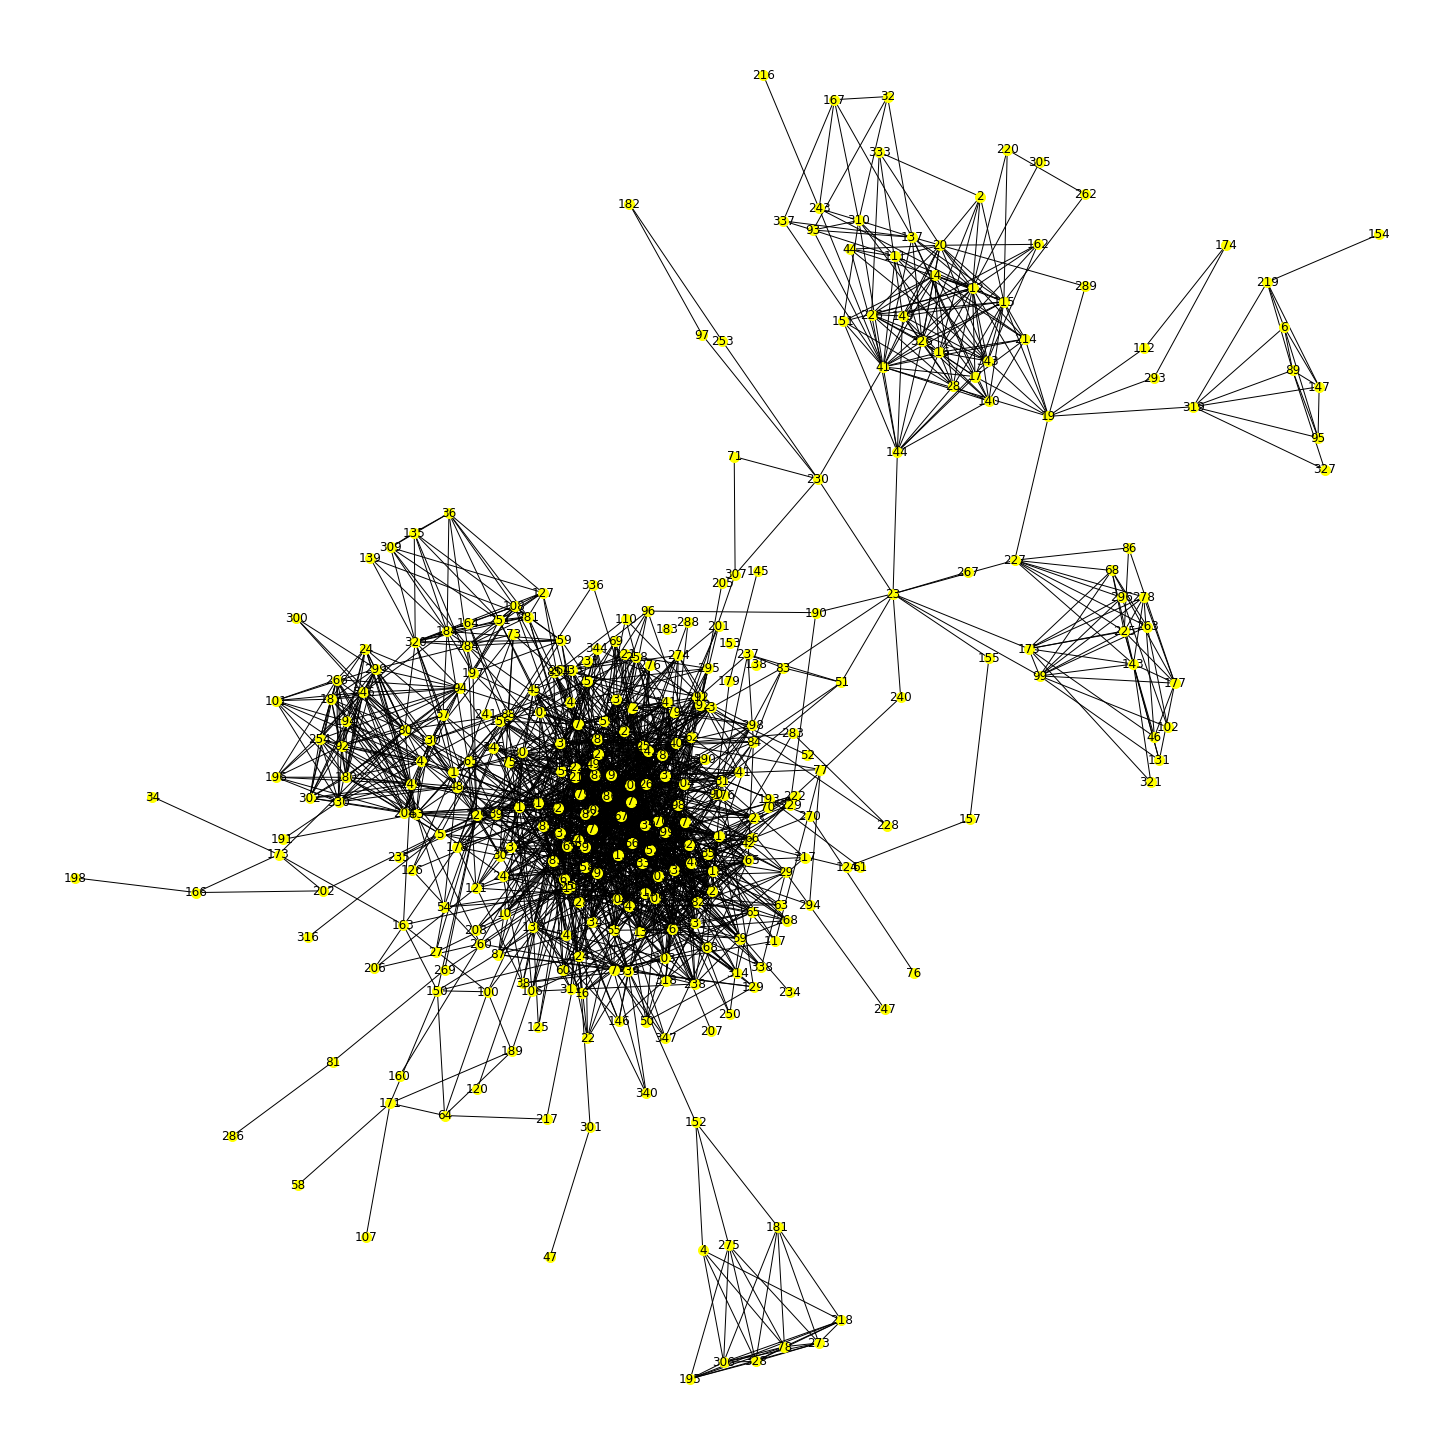

In [70]:
#building training graph
X_train_exist = train_df[train_df['edge_exists'] == 1]
subset = X_train_exist[["source_node", "dest_node"]]
tuples = [tuple(x) for x in subset.values]
edge_tuples = [(i,str(j)) for i,j in tuples]
#print(edge_tuples)

train_graph = nx.Graph()
train_graph.add_nodes_from(node_list)
train_graph.add_edges_from(edge_tuples)
print(len(train_graph.edges))
display_graph(train_graph)

In [71]:
msk = ~msk
# for i in output:
#     print(i)
#print(output)
print(len(test_df), len(output))
print(len(edge_tuples))

for i in range(len(output)):
    if output[i][0]:
        edge_tuples.append((test_df["source_node"].iloc[i], test_df["dest_node"].iloc[i]))

print(len(edge_tuples))

1044 1044
2010
2507


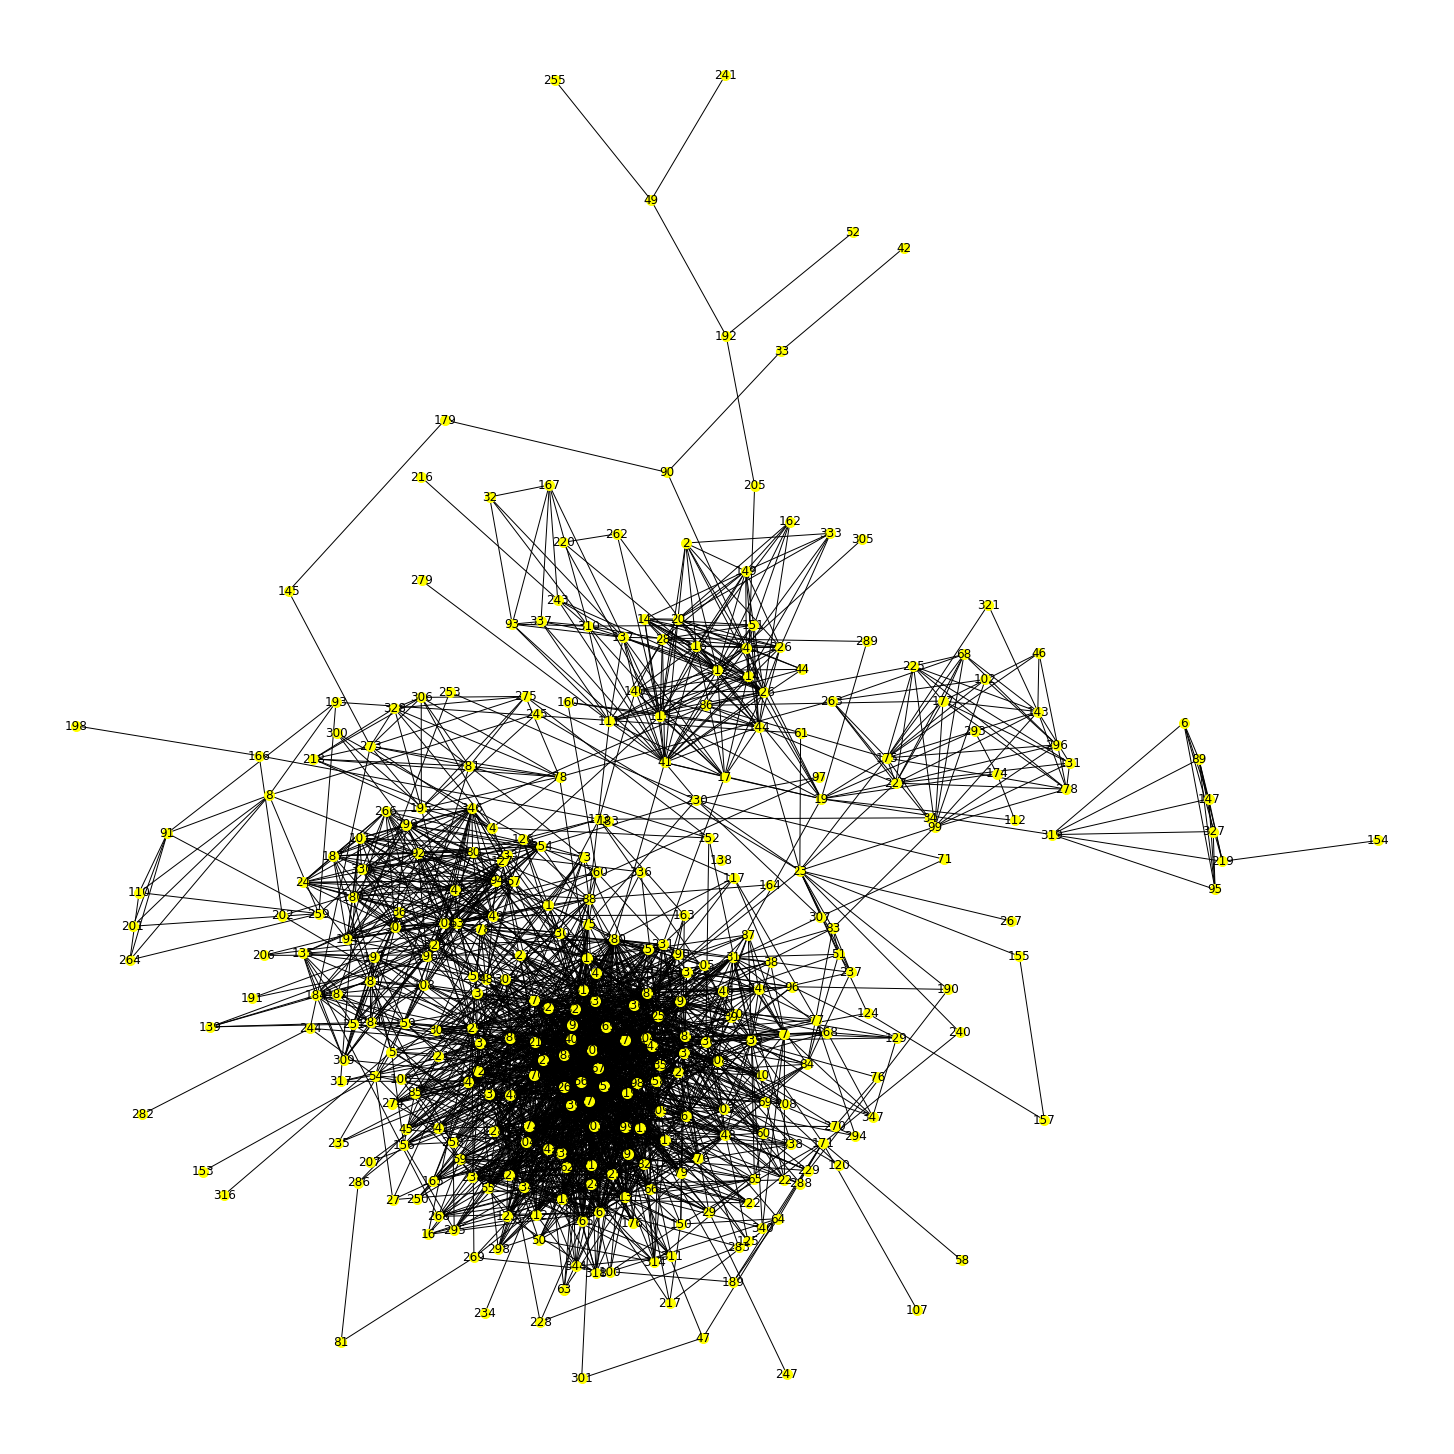

In [72]:
test_graph = nx.Graph()
test_graph.add_nodes_from(node_list)
test_graph.add_edges_from(edge_tuples)
display_graph(test_graph)

In [84]:
print("-----RESULTS-----\n\n")
print("Stochastic Gradient Descent Linear Classifier: \t", clf.score(X_test, y_test))
print("Logistic Regression:                           \t", clf2.score(X_test, y_test))
print("Linear SVC:                                    \t", clf3.score(X_test, y_test))
print("Gaussian Naive Bayes:                          \t", clf4.score(X_test, y_test))
print('Neural Network:                                \t', test_acc)

-----RESULTS-----


Stochastic Gradient Descent Linear Classifier: 	 0.7528735632183908
Logistic Regression:                           	 0.7825670498084292
Linear SVC:                                    	 0.7863984674329502
Gaussian Naive Bayes:                          	 0.7059386973180076
Neural Network:                                	 0.802682
